# Fine Tuning BERT for Sentiment Analysis with PyTorch

The only difference between this notebook and [train.ipynb](./train.ipynb) is that this version freezes
the BERTimbau Layers

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = True  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


## Installing and Importing Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"
if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2532, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1269
-1    1021
 0     242
Name: count, dtype: int64

In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2025, 2)

In [22]:
test_data.shape

(507, 2)

## Create a PyTorch Dataset

In [23]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = TOKEN_MAX_LENGTH

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [25]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [27]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)

        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [28]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [29]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [30]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title("Training and Test Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [31]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    return train_losses, test_losses

## Model Evaluation functions

In [32]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [33]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [34]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

### Training the Model

In [35]:
model = GlassdoorReviewsClassifier(num_labels).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [36]:
loss_fun = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [38]:
n_total_steps = len(train_loader)
n_total_steps

127

In [39]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 1.0645
Training Batch 32/127, 		 loss = 1.0486
Training Batch 48/127, 		 loss = 1.0319
Training Batch 64/127, 		 loss = 1.0110
Training Batch 80/127, 		 loss = 1.0627
Training Batch 96/127, 		 loss = 1.0117
Training Batch 112/127, 		 loss = 1.0580

Evaluating Batch 16/127, 		 loss = 1.0199
Evaluating Batch 32/127, 		 loss = 0.9698

Train Loss: 1.0339903409086812, 		 Test Loss: 0.9932140596210957



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 1.0148
Training Batch 32/127, 		 loss = 1.0314
Training Batch 48/127, 		 loss = 0.9858
Training Batch 64/127, 		 loss = 0.9262
Training Batch 80/127, 		 loss = 0.9447
Training Batch 96/127, 		 loss = 0.8849
Training Batch 112/127, 		 loss = 0.8699

Evaluating Batch 16/127, 		 loss = 0.9173
Evaluating Batch 32/127, 		 loss = 0.8380

Train Loss: 0.9531625612514225, 		 Test Loss: 0.8730825129896402



-------------------- Epo

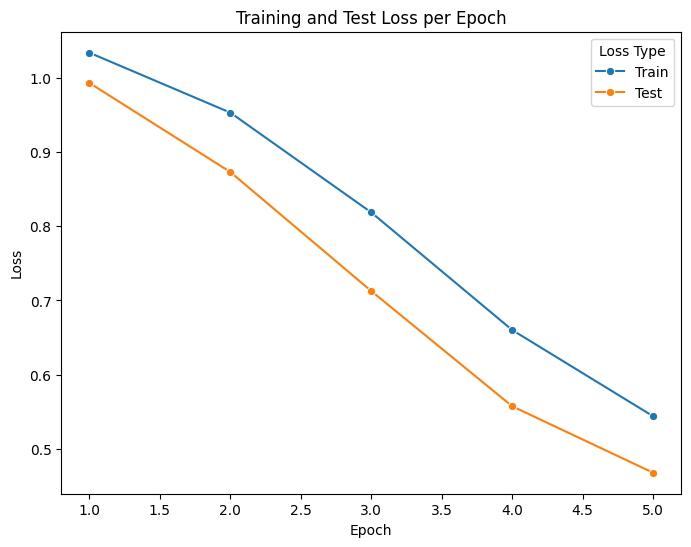

In [40]:
show_loss(train_losses, test_losses)

### Evaluating the Model

In [41]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [42]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.90      0.94      0.92       269
           2       0.76      0.91      0.83       187

    accuracy                           0.84       507
   macro avg       0.55      0.62      0.58       507
weighted avg       0.76      0.84      0.80       507



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print(accuracy_score(all_labels, all_preds))

0.8382642998027613


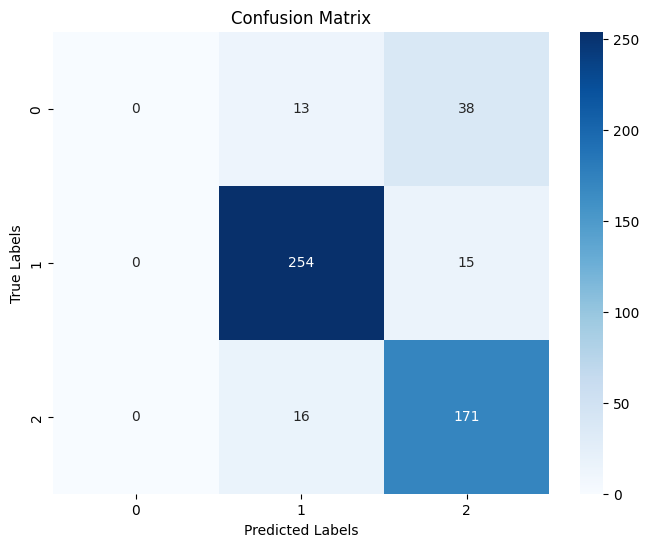

In [44]:
show_confusion_matrix(all_labels, all_preds)

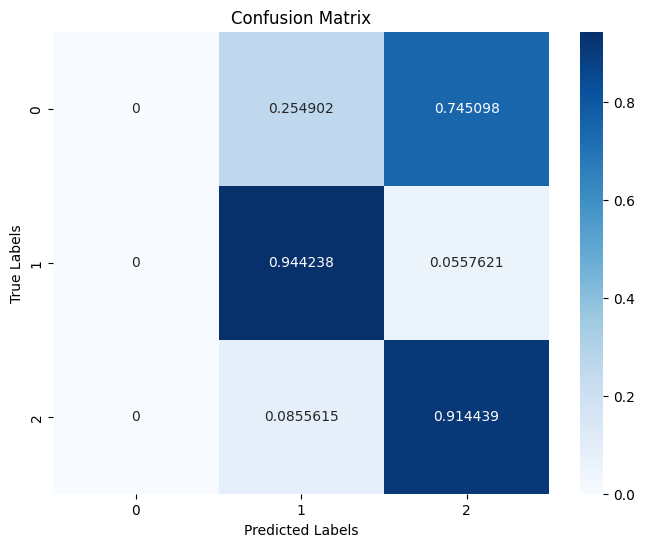

In [45]:
show_confusion_matrix(all_labels, all_preds, normalize="true")

### Saving the model

In [46]:
torch.save(model.state_dict(), f"bertimbau-glassdoor-reviews-epoch_{EPOCHS}.bin")

### Loading the model

In [47]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [48]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

### Sample prediction

In [49]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [50]:
predict_reviews(model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.041521
positive    0.869374
negative    0.089105
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.086275
positive    0.338605
negative    0.575120
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.194098
positive    0.155010
negative    0.650892
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [51]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [52]:
filtered_dataset.shape

(2532, 2)

In [53]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     242
Name: count, dtype: int64

In [54]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [55]:
oversampled_filtered_dataset.shape

(3258, 2)

In [56]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     968
Name: count, dtype: int64

### Training the Model

In [57]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [58]:
oversampled_train_dataset = GlassdoorReviewsDataset(oversampled_train_data, tokenizer)
oversampled_test_dataset = GlassdoorReviewsDataset(oversampled_test_data, tokenizer)

In [59]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [60]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)

In [61]:
loss_fun = nn.CrossEntropyLoss()

In [62]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)

In [63]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

In [64]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 1.1219
Training Batch 32/163, 		 loss = 1.0689
Training Batch 48/163, 		 loss = 1.0659
Training Batch 64/163, 		 loss = 1.0657
Training Batch 80/163, 		 loss = 1.0959
Training Batch 96/163, 		 loss = 1.0703
Training Batch 112/163, 		 loss = 1.0600
Training Batch 128/163, 		 loss = 1.0794
Training Batch 144/163, 		 loss = 1.0778
Training Batch 160/163, 		 loss = 1.0486

Evaluating Batch 16/163, 		 loss = 1.0329
Evaluating Batch 32/163, 		 loss = 1.0081

Train Loss: 1.0782628125208287, 		 Test Loss: 1.030379006639123



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 1.0559
Training Batch 32/163, 		 loss = 1.0317
Training Batch 48/163, 		 loss = 1.0256
Training Batch 64/163, 		 loss = 0.9924
Training Batch 80/163, 		 loss = 0.9184
Training Batch 96/163, 		 loss = 1.0543
Training Batch 112/163, 		 loss = 0.9912
Training Batch 128/163, 		 loss = 0.9320
Training Batch 

### Evaluating the Model

In [65]:
len(oversampled_train_losses)

5

In [66]:
len(oversampled_test_losses)

5

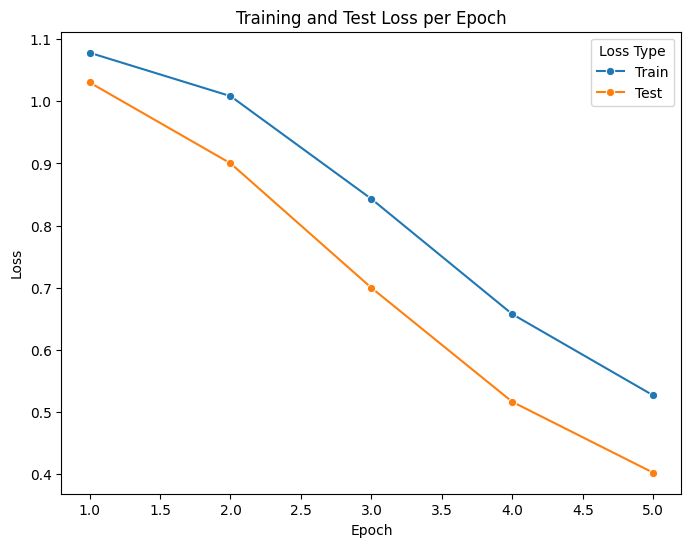

In [67]:
show_loss(oversampled_train_losses, oversampled_test_losses)

In [68]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [69]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       197
           1       0.81      0.94      0.87       256
           2       0.80      0.76      0.78       199

    accuracy                           0.82       652
   macro avg       0.82      0.81      0.81       652
weighted avg       0.82      0.82      0.82       652



In [70]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.8190184049079755


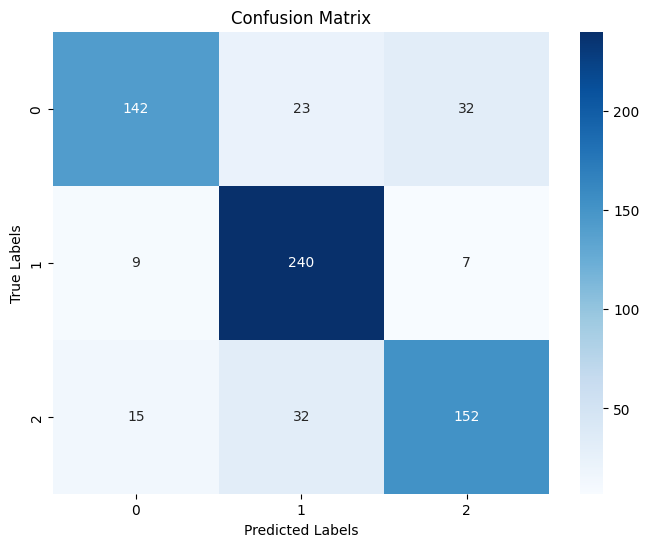

In [71]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

### Saving the model

In [72]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
)

### Loading the model

In [73]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [74]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Sample prediction

In [75]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [76]:
predict_reviews(oversampled_model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.034902
positive    0.896483
negative    0.068615
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.09496
positive    0.39375
negative    0.51129
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.892021
positive    0.043461
negative    0.064518
Name: 0, dtype: float64


